In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Shapley value defintion
Given a set of n elements, $U := \{1, \cdots, n\}$ and a function

$g: 2^U \rightarrow \mathbb{R}$ with $g(U) \neq 0$, $g(\varnothing)=0$

define $C(j|T) := g(T \cup \{j\}) - g(T)$ with $T \subseteq U$.

Feture i's contribution:

$\phi_i := \sum_{T \subseteq U} \frac{|T|! (n-1-|T|)!}{n!} C(i|T)$

where
$g(T) := f_T(x_T) - f(x')$ with $f_\varnothing(x_\varnothing) = f(x')$ for some baseline $x'$. 

$f_T(x_T) := \mathbb{E}[ f(x_T, X_{\bar{T}}) | z]$  where $z$ is a hyperparameter

previous approaches considers
- unconditional: $z := \varnothing$
- conditional: $z := \{X_T = x_T \}$

we in addition consider using a causal graph
- do: $z := \{do(X_T = x_T)\}$

## Assumptions
- no unobserved confounders

## Axioms

1. Any ordering of the source node is equally likely (eliminate reverse dfs)
2. Expanding a node won't affect the contribution of irrelevant edges (eliminate permutation of path and reverse dfs with single source by revealing the model node)
3. Efficiency
4. Linearity
5. NULL player

Want to show the dfs uniquely satisfies those axioms among path attribution methods. Edge attribution method is induced from the path attribution. 
Note that we don't have symmetry. Also note that axiom 1 may be eliminable.

## Noise distribution

For continuous variables, we assume data is generated through the data generating function with added Gaussian Noise (consistent with the assumption of regression problems).

For categorical variables, we assume the data is generated according to a categorical distribution, we perform inverse probability sampling by sampling from a uniform distribution.

In [185]:
import networkx as nx
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, Graph

# 0 baseline model

$\text{health status} \in \{0, 1\}$

$\text{portable scanner} \in \{0, 1\}$

$\text{mortality probability prediction} \in [0, 1]$


```python
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True) # U(0, 1)
    x2 = Node('scanner type', lambda x1, n2: int(0.9 > n2) if x1 <= 0.1 else int(0.3 > n2), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
```


----> using order [scanner type noise, health status]
baselines scanner type noise: 0.9659375643059274, health status: 1
turn on node scanner type noise from 0.48178381698059547 to 0.48178381698059547


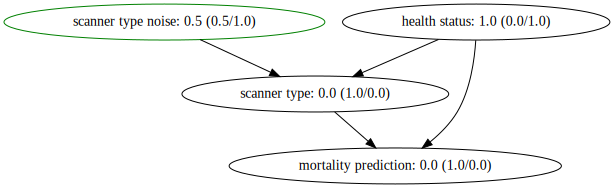

turn on edge scanner type noise->scanner type


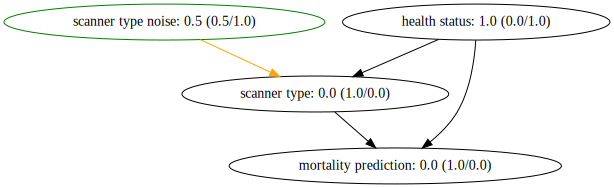

scanner type changes from 0 to 0


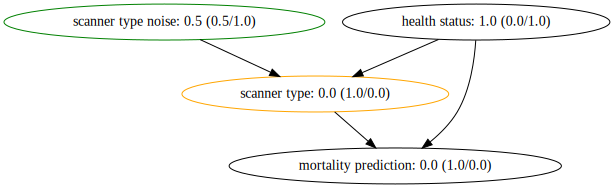

turn on edge scanner type->mortality prediction


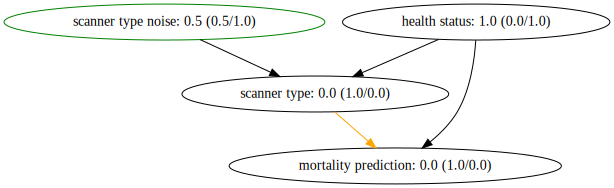

mortality prediction changes from 0 to 0


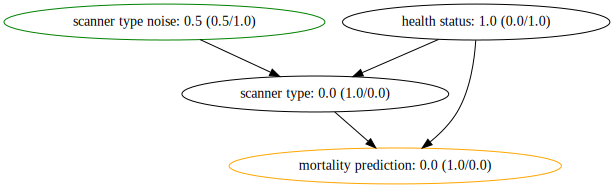

assign 0 credits to scanner type->mortality prediction


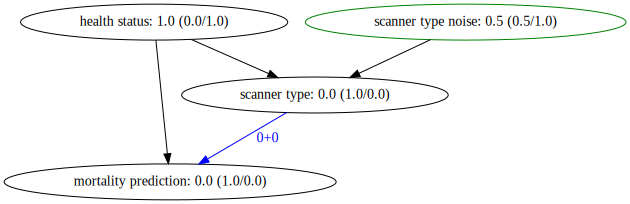

assign 0 credits to scanner type noise->scanner type


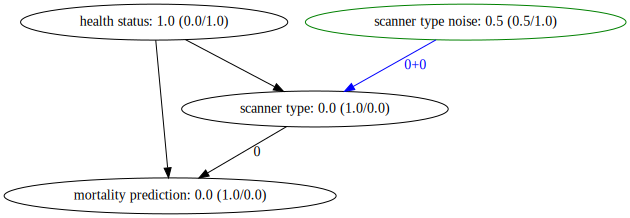

turn on node health status from 0 to 0


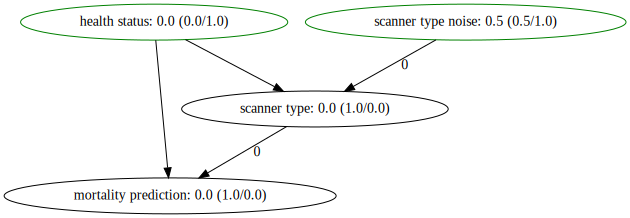

turn on edge health status->scanner type


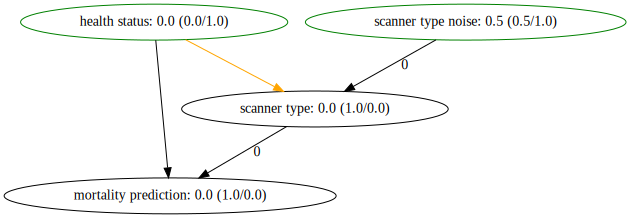

scanner type changes from 0 to 1


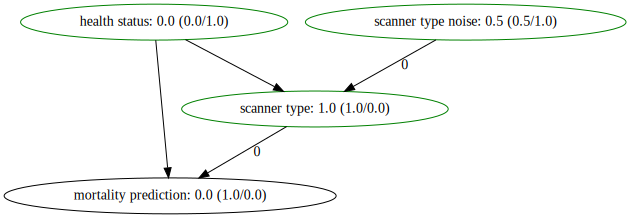

turn on edge scanner type->mortality prediction


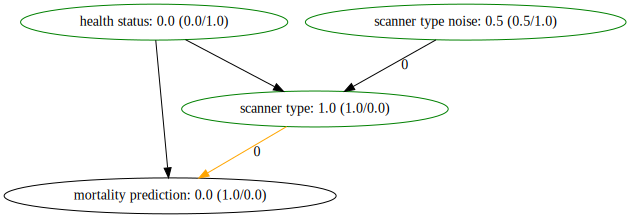

mortality prediction changes from 0 to 1


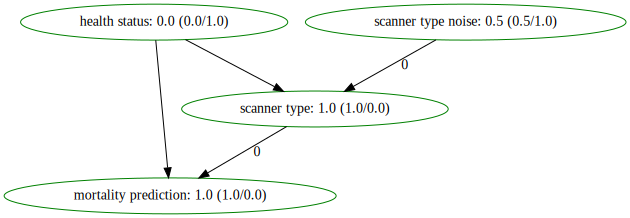

assign 1 credits to scanner type->mortality prediction


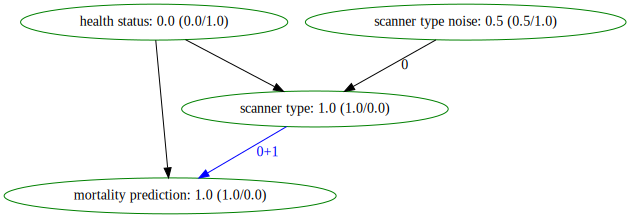

assign 1 credits to health status->scanner type


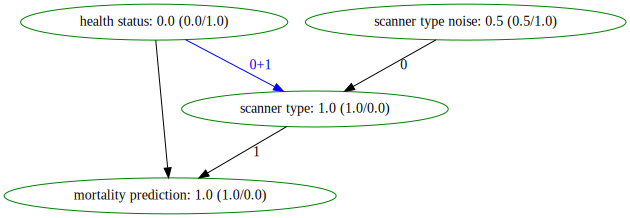

turn on edge health status->mortality prediction


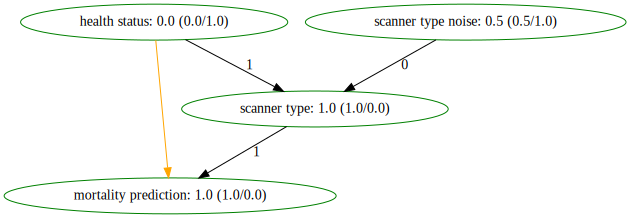

mortality prediction changes from 1 to 1


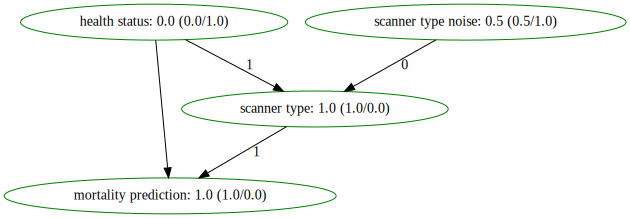

assign 0 credits to health status->mortality prediction


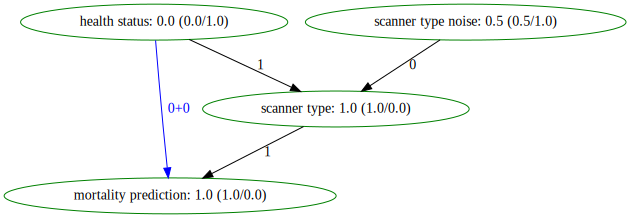

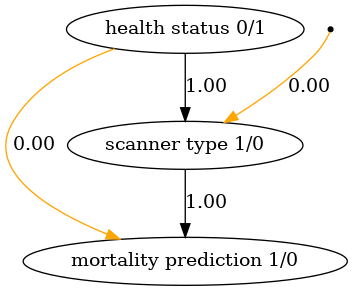

In [253]:
scanner_type_noise_baseline = np.random.uniform(0.3, 1) 
scanner_type_noise_target = np.random.uniform(0, 0.9)

# scanner_type_noise_baseline = 0.9 # np.random.uniform(0.3, 1) 
# scanner_type_noise_target = 0 # np.random.uniform(0, 0.9)

'''
current value: health status, scanner type, mortality
{
    (0, 1, 1): [(0-1, 0-0.89999)]
    (0, 0, 0): [(0-1. 0.9-1)]
}
'''
# [(0, 0): (0, 1, 1), (0, 0.3): , (0, 0.9): (0, 0, 0)]

def health_data():
    '''synthetic health data'''
    health_status = 1
    scanner_type_noise = scanner_type_noise_baseline
    scanner_type = 0 
    return {
        'health status': health_status,
        'scanner type': scanner_type,
        'scanner type noise': scanner_type_noise
    }

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: int(0.9 > n2) if x1 <= 0.1 else int(0.3 > n2), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y], health_data, 
                  lambda: {
                     'health status': 0,
                     'scanner type noise': scanner_type_noise_target,
                     'scanner type': 1,
                     'mortality prediction': 1
                 })
   
    return graph

cf = CreditFlow(verbose=True, nruns=1, visualize=True)
graph = build_health_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

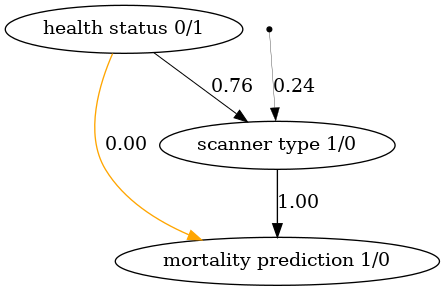

In [254]:
'''
current value: health status, scanner type, mortality
{
    (0, 1, 1): [(0-1, 0-0.89999)]
    (0, 0, 0): [(0-1. 0.9-1)]
}

to make sure value changes from (1, 0, 0) -> (0, 1, 1)
we need baseline noise 0.3-1
        target noise 0-0.899999
'''
# [(0, 0): (0, 1, 1), (0, 0.3): , (0, 0.9): (0, 0, 0)]

def health_data():
    '''synthetic health data'''
    health_status = 1
    scanner_type_noise = np.random.uniform(0.3, 1)
    scanner_type = 0 
    return {
        'health status': health_status,
        'scanner type': scanner_type,
        'scanner type noise': scanner_type_noise
    }

def build_health_graph(verbose=False):
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: int(0.9 > n2) if x1 <= 0.1 else int(0.3 > n2), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y], health_data, 
                  lambda: {
                     'health status': 0,
                     'scanner type noise': np.random.uniform(0, 0.9),
                     'scanner type': 1,
                     'mortality prediction': 1
                 }, verbose=verbose)
   
    return graph

cf = CreditFlow(verbose=False, nruns=5000)
graph = build_health_graph(verbose=False)
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

Health status has limited effect in this case when

1. target noise < 0.3 (health status has no effect when applied second)
2. base noise > 0.9 (health status has no effect when applied first)

which has probablity $1/3 * 1/2 + 1/7 * 1/2 = 0.238$, matching the result we s

# previous models

$\text{health status} \sim U([0, 1])$

$P(\text{scanner type = "portable"}) = 
\begin{cases}
    0.9, & \text{if } \text{health status} \leq 0.1 \\
    0.3,               & \text{otherwise}
\end{cases}$

$\text{mortality} =
\begin{cases}
    1, & \text{if } \text{health status} \leq 0.1 \\
    0,               & \text{otherwise}
\end{cases}$


{'health status': 0.41533457568181875, 'scanner type': 0, 'mortality': 0}
baseline additive noise for scanner type is -0.3
outcome additive noise for scanner type is 0.09999999999999998


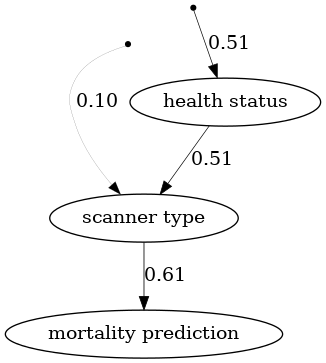

In [8]:
def health_data():
    '''synthetic health data'''
    health_status = np.random.uniform(0, 1)
    scanner_type = np.random.choice([0, 1], 
                                    p=[0.1 if health_status <= 0.1 else 0.7,
                                       0.9 if health_status <= 0.1 else 0.3]) 
    mortality = 1 if health_status <= 0.1 else 0
    return {
        'health status': health_status,
        'scanner type': scanner_type,
        'mortality': mortality
    }

print(health_data())

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2->x3, y = f(x1, x2, x3)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 0.9 if x1 <= 0.1 else 0.3, [x1])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, x2, y], health_data, 
                 {
                     'health status': 0.1,
                     'scanner type': 1,
                     'mortality prediction': 1
                 })
   
    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=1000)
graph = build_health_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

# Can handle AND
```python
 y  = Node('mortality', lambda x1, x2: (x1 <= 0.1) and x2, 
              [x1, x2], is_target_node=True)
```

{'health status': 0.6563668102649248, 'scanner type': 0, 'mortality': 0}


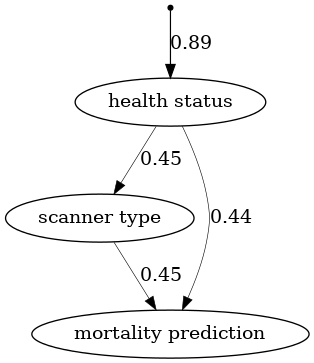

In [9]:
def health_data():
    '''synthetic health data'''
    health_status = np.random.uniform(0, 1)
    scanner_type = np.random.choice([0, 1], 
                                    p=[0 if health_status <= 0.1 else 1,
                                       1 if health_status <= 0.1 else 0]) 
    mortality = 1 if health_status <= 0.1 else 0
    return {
        'health status': health_status,
        'scanner type': scanner_type,
        'mortality': mortality
    }

print(health_data())

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2->x3, y = f(x1, x2, x3)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 1 if x1 <= 0.1 else 0, [x1])
    # x2 = Node('scanner type')
    y  = Node('mortality prediction', lambda x1, x2: (x1 <= 0.1) and x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, x2, y], health_data, 
                 {
                     'health status': 0.1,
                     'scanner type': 1,
                     'mortality prediction': 1
                 })
   
    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=3000)
graph = build_health_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

# Inconsistent cases

This fails edge first flow (flow1.py) because the red edge can only appear first or last.

A simple graph


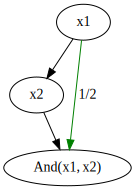

In [31]:
print('A simple graph')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('y', 'And(x1, x2)')

dot.edges(['12', '2y'])
dot.edge('1', 'y', color='green', label='1/2')
dot

sample baseline {'x1': 0, 'x2': 0, 'target': 0}
target values {'x1': 1, 'x2': 1, 'target': 1}


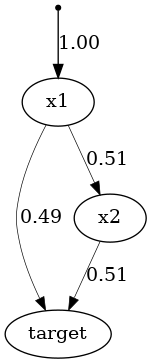

In [13]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    y  = Node('target', lambda x1, x2: int(x1 + x2 >= 2), 
              [x1, x2], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, y], 
              # sample baseline
              lambda: {'x1': 0, 'x2': 0, 'target': 0},
              # target to explain
              {'x1': 1, 'x2': 1, 'target': 1})

    # verbose print
    baseline = graph.baseline_sampler()
    baseline[y.name] = y.f(*[arg.baseline for arg in y.args])
    print('sample baseline', baseline)
    print('target values', graph.target_values)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=1000)
graph = build_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

adding an intermediate node from x1 to x2


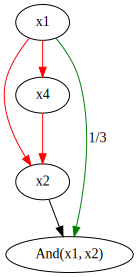

In [177]:
print('adding an intermediate node from x1 to x2')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
# dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And(x1, x2)')

dot.edges(['2y'])
dot.edge('1', 'y', color='green', label='1/3')
dot.edge('1', '4', color='red')
dot.edge('4', '2', color='red')
dot.edge('1', '2', color='red')
display(dot)

sample baseline {'x1': 0, 'x2': 0, 'x4': 0, 'target': 0}
target values {'x1': 1, 'x2': 1, 'x4': 1, 'target': 1}


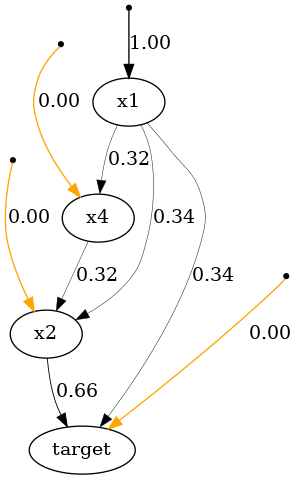

In [47]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x4 = Node('x4', lambda x1: x1, [x1])
    x2 = Node('x2', lambda x1, x4: (x4 + x1)/2, [x1, x4])
    y  = Node('target', lambda x1, x2: int(x1 + x2 >= 2), 
              [x1, x2], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, x4, y], 
              # sample baseline
              lambda: {'x1': 0, 'x2': 0, 'x4': 0, 'target': 0},
              # target to explain
              {'x1': 1, 'x2': 1,  'x4': 1, 'target': 1})

    # verbose print
    baseline = graph.baseline_sampler()
    baseline[y.name] = y.f(*[arg.baseline for arg in y.args])
    print('sample baseline', baseline)
    print('target values', graph.target_values)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=3000)
graph = build_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

works in this case: adding an intermediate node from x2 to yhat


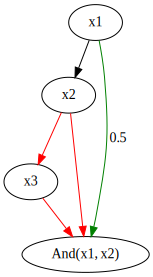

In [39]:
print('works in this case: adding an intermediate node from x2 to yhat')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('y', 'And(x1, x2)')

dot.edges(['12'])
dot.edge('1', 'y', color='green', label='0.5')
dot.edge('2', '3', color='red')
dot.edge('2', 'y', color='red')
dot.edge('3', 'y', color='red')
dot

sample baseline {'x1': 0, 'x2': 0, 'x3': 0, 'target': 0}
target values {'x1': 1, 'x2': 1, 'x3': 1, 'target': 1}


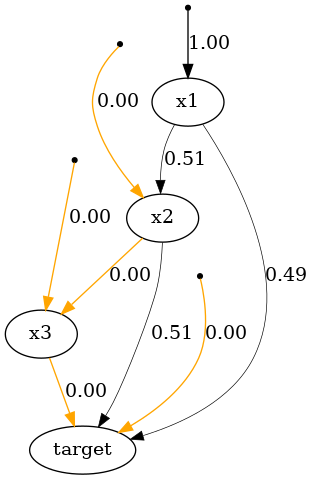

In [34]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    x3 = Node('x3', lambda x1: x1, [x2])
    y  = Node('target', lambda x1, x2, x3: int(x1 + x2 >= 2), 
              [x1, x2, x3], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, x3, y], 
              # sample baseline
              lambda: {'x1': 0, 'x2': 0, 'x3': 0, 'target': 0},
              # target to explain
              {'x1': 1, 'x2': 1,  'x3': 1, 'target': 1})

    # verbose print
    baseline = graph.baseline_sampler()
    baseline[y.name] = y.f(*[arg.baseline for arg in y.args])
    print('sample baseline', baseline)
    print('target values', graph.target_values)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=100)
graph = build_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

need to pad a copy input node before expanding the computation of x2


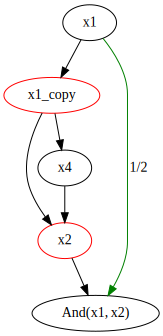

In [50]:
print('need to pad a copy input node before expanding the computation of x2')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2', color='red')
dot.node('3', 'x1_copy', color='red')
dot.node('4', 'x4')
dot.node('y', 'And(x1, x2)')

dot.edges(['2y'])
dot.edge('1', 'y', color='green', label='1/2')
dot.edge('1', '3')
dot.edge('3', '4')
dot.edge('4', '2')
dot.edge('3', '2')
dot

sample baseline {'x1': 0, 'x2': 0, 'x4': 0, 'x1_copy': 0, 'target': 0}
target values {'x1': 1, 'x2': 1, 'x4': 1, 'target': 1, 'x1_copy': 1}


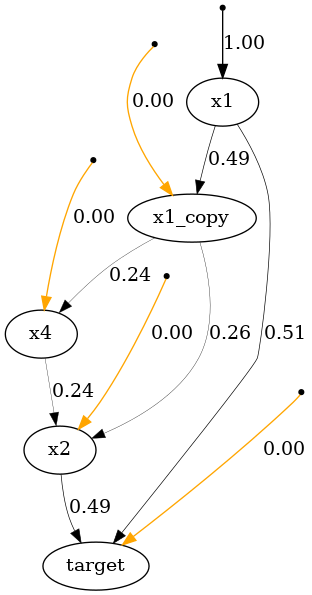

In [52]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x1_copy = Node('x1_copy', lambda x1: x1, [x1])
    x4 = Node('x4', lambda x1_copy: x1_copy, [x1_copy])
    x2 = Node('x2', lambda x1_copy, x4: (x4 + x1_copy) / 2, [x1_copy, x4])
    y  = Node('target', lambda x1, x2: int(x1 + x2 >= 2), 
              [x1, x2], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, x1_copy, x4, y], 
              # sample baseline
              lambda: {'x1': 0, 'x2': 0, 'x4': 0, 'x1_copy': 0, 'target': 0},
              # target to explain
              {'x1': 1, 'x2': 1,  'x4': 1, 'target': 1, 'x1_copy': 1})

    # verbose print
    baseline = graph.baseline_sampler()
    baseline[y.name] = y.f(*[arg.baseline for arg in y.args])
    print('sample baseline', baseline)
    print('target values', graph.target_values)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=1000)
graph = build_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')